In [1]:
from google.colab import drive

drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
n_atoms=10000

def read_file(f):
    
    temp=np.zeros((10000,2))
    for j in range (10):
        line=f.readline()
        if line=="":
            return temp
        #if line=='ITEM: BOX BOUNDS pp pp pp':
        if line=='ITEM: ATOMS id type x y z \n':
            for i in range(n_atoms):
                line=f.readline()

                line=line.split(' ')
                temp[i]=[float(line[2]),float(line[3])]
            break
                
    return temp

def full_read_file(name_fime):
    img=[]
    with open(name_fime,'r') as f:
        temp=1
        while True:
            temp=read_file(f)
            if temp.all()==0:
                break
            img.append(temp)
    img=np.array(img)
    print(img.shape)
    return img

#img=full_read_file('/content/drive/My Drive/FPT/T49K1.coord')

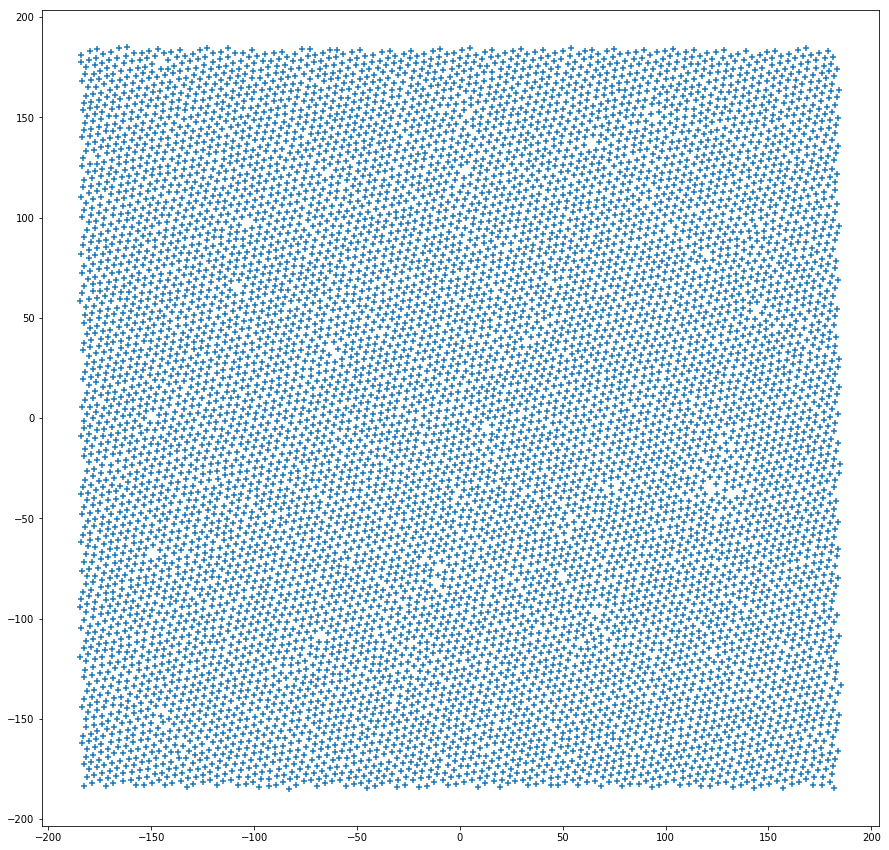

In [44]:
plt.figure(figsize=(15,15))
plt.scatter(img[1,:,0],img[1,:,1],marker="+")

In [0]:
names=['43','49','50','51','52_1','52_2','52','53','54','55','56','57','58','59','60','61','62','63']

In [5]:
len(names)

18

In [7]:
X=np.zeros((11,801,10000,2))
for name,i in zip(names[1:11],range(11)):
  img=full_read_file('/content/drive/My Drive/FPT/T'+name+'K1.coord')
  
  X[i]=img
  '''
  plt.figure(figsize=(15,15))
  plt.scatter(img[1,:,0],img[1,:,1],marker="+")
  plt.title(name)
  plt.show()
  '''

(801, 10000, 2)
(801, 10000, 2)
(801, 10000, 2)
(801, 10000, 2)
(801, 10000, 2)
(801, 10000, 2)
(801, 10000, 2)
(801, 10000, 2)
(801, 10000, 2)
(801, 10000, 2)


In [8]:
Y=[0,0,0,1,1,1,1,2,2,2,2,2,2,2,2,2,2]
print(len(Y))

17


In [6]:
from torch import nn
import torch
import torch.nn.functional as F

use_cuda = torch.cuda.is_available()

print("Torch version:", torch.__version__)
if use_cuda:
    print("Using GPU")
else:
    print("Not using GPU")


Torch version: 1.1.0
Using GPU


In [0]:
Y=np.array(Y)
Y=torch.from_numpy(Y[:10])
X=torch.from_numpy(X[:10])

In [0]:
class Reshape(nn.Module):
    def __init__(self, shape):
        nn.Module.__init__(self)
        self.shape=shape
    def forward(self,input):
        return input.view(self.shape)
      
class MyModel(nn.Module):
  def __init__(self,inp_size,out_size):
    super(self.__class__, self).__init__()
    self.inp_size=inp_size
    self.out_size=out_size
    self.layers=nn.Sequential(nn.ConvTranspose2d(inp_size,15,kernel_size=(2,2)),
                              nn.ReLU(),
                              nn.BatchNorm2d(15),
                              nn.ConvTranspose2d(15,15,kernel_size=(2,2)),
                              nn.ReLU(),
                              nn.BatchNorm2d(15),
                              nn.ConvTranspose2d(15,15,kernel_size=(2,2)),
                              nn.ReLU(),
                              nn.BatchNorm2d(15),
                              nn.Conv2d(15,5,kernel_size=(2,2)),
                              nn.ReLU(),
                              Reshape((1,5*10002*4)),
                              nn.Linear(5*10002*4,256),
                              nn.ReLU(),
                              nn.Linear(256,16),
                              nn.ReLU(),
                              nn.Linear(16,out_size))
                             
                             
  def forward(self,input):
    output=self.layers(input)
    return output
  
 

In [0]:
def accuracy(out,y):
  output=np.zeros(out.shape[0])
  for i in range(out.shape[0]):
    output[i]= (np.argmin(out[i])==np.argmin(y[i]))
    #print(np.argmax(out[i]))
    #print(np.argmax(y[i]))
  #print(output)
  return np.mean(output)

In [0]:
def train(model,X,Y,optimizer,criterion,n_epochs,device):
  model.train()
  loss_hist=[] 
  
  accur=[]
  
  if device:
    model.cuda()
  
  
  for epoch in range(n_epochs):
    out_hist=[]
    true_y=[]
    temp=0
    for x,y in zip(X,Y):
      x=x.view([1,801,10000,2]).float()
      optimizer.zero_grad()
      if device:
        x=x.cuda()
        y=y.cuda()
        
      out=model(x)
      
      #print(out.shape)
      #print(y.shape)

      loss=criterion(out,y)
      loss.backward()
      optimizer.step()
      
      
      temp+=loss.item()
      #print(out)
      #print(y)
      out_hist.append(out.cpu().detach().numpy())
      true_y.append(y.cpu().detach().numpy())
      
    loss_hist.append(temp)
    
    out_hist=np.array(out_hist)
    true_y=np.array(true_y)
    accur.append(accuracy(out_hist,true_y))
    #print(accuracy(out_hist,true_y))
  
  plt.plot(loss_hist,label='loss')
  plt.title('loss function')
  plt.xlabel('n_epochs')
  plt.ylabel('loss')
  plt.legend()
  plt.show()
  
  plt.plot(accur,label='accuracy')
  plt.title('accuracy')
  plt.xlabel('n_epochs')
  plt.ylabel('accur')
  plt.legend()
  plt.show()
  
  
  print(loss_hist)
  model.eval()
  
  return loss_hist,accur

In [0]:
from sklearn.preprocessing import LabelBinarizer
lb=LabelBinarizer()
lb.fit(Y.numpy())

Y=torch.from_numpy(lb.transform(Y.numpy())).float()

del lb

In [0]:
model=MyModel(801,3)
optimizer=torch.optim.Adam(model.parameters(), lr=1e-3)
criterion=nn.MSELoss()

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:443: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([1, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


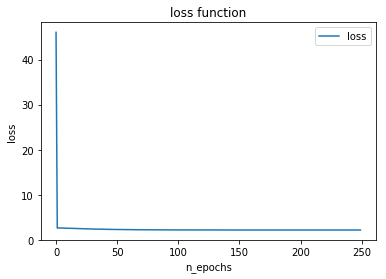

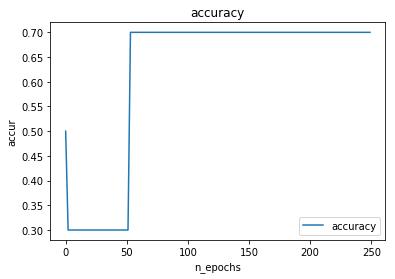

[46.04302342236042, 2.6269664764404297, 2.6663841009140015, 2.660238102078438, 2.6521927267313004, 2.643205240368843, 2.6337115317583084, 2.623932331800461, 2.6139934957027435, 2.603976249694824, 2.593938499689102, 2.5839236974716187, 2.5739658772945404, 2.5640923529863358, 2.5543248057365417, 2.5446813851594925, 2.5351763516664505, 2.5258214473724365, 2.5166261792182922, 2.5075979083776474, 2.4987428933382034, 2.4900654703378677, 2.4815691858530045, 2.473256468772888, 2.4651287347078323, 2.457187205553055, 2.4494319707155228, 2.4418626874685287, 2.4344786554574966, 2.4272786676883698, 2.4202612340450287, 2.4134246110916138, 2.406766787171364, 2.400285452604294, 2.393978014588356, 2.3878419250249863, 2.3818744868040085, 2.3760726302862167, 2.3704335540533066, 2.3649541288614273, 2.359631195664406, 2.354461744427681, 2.3494425266981125, 2.3445702493190765, 2.339841768145561, 2.335253894329071, 2.3308032751083374, 2.3264866769313812, 2.32230107486248, 2.318243071436882, 2.314309626817703

In [29]:
loss,accur=train(model,X[:10],Y[:10], optimizer,criterion,250,use_cuda)

No handles with labels found to put in legend.


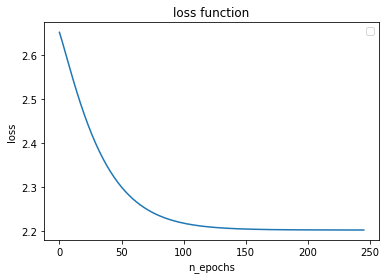

In [32]:
plt.plot(loss[4:])
plt.title('loss function')
plt.xlabel('n_epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [0]:
torch.save(model.state_dict(), '/content/drive/My Drive/FPT/model.pth')

In [0]:
names=['43','49','50','51','52_1','52_2','52','53','54','55','56','57','58','59','60','61','62','63']

In [183]:
X=np.zeros((17,801,10000,2))
for name,i in zip(names[1:],range(len(names))):
  img=full_read_file('/content/drive/My Drive/FPT/T'+name+'K1.coord')
  X[i]=img
Y=[0,0,0,1,1,1,1,2,2,2,2,2,2,2,2,2,2]
print(len(Y))


from sklearn.preprocessing import LabelBinarizer
lb=LabelBinarizer()
lb.fit(Y)

Y=torch.from_numpy(lb.transform(Y)[11:]).float()

del lb

X=torch.from_numpy(X[11:])

(801, 10000, 2)
(801, 10000, 2)
(801, 10000, 2)
(801, 10000, 2)
(801, 10000, 2)
(801, 10000, 2)
(801, 10000, 2)
(801, 10000, 2)
(801, 10000, 2)
(801, 10000, 2)
(801, 10000, 2)
(801, 10000, 2)
(801, 10000, 2)
(801, 10000, 2)
(801, 10000, 2)
(801, 10000, 2)
(801, 10000, 2)
17


In [0]:
def validate(model,X,Y,use_cuda):
  model.eval()
  out_hist=[]
  true_y=[]
  print(X.shape)
  print(Y.shape)
  for x,y in zip(X,Y):
    x=x.view([1,801,10000,2]).float()
    if use_cuda:
        x=x.cuda()
        y=y.cuda()
    out=model(x)
      
    out_hist.append(out.cpu().detach().numpy())
    true_y.append(y.cpu().detach().numpy())
      
    
  out_hist=np.array(out_hist)
  true_y=np.array(true_y)
  return accuracy(out_hist,true_y),true_y,out_hist

In [194]:
accur,_,_=validate(model,X,Y,use_cuda)

torch.Size([6, 801, 10000, 2])
torch.Size([6, 3])


In [196]:
accur

1.0

In [0]:
X=np.zeros((17,801,10000,2))
for name,i in zip(names[1:],range(len(names))):
  img=full_read_file('/content/drive/My Drive/FPT/T'+name+'K1.coord')
  X[i]=img
Y=[0,0,0,1,1,1,1,2,2,2,2,2,2,2,2,2,2]
print(len(Y))


from sklearn.preprocessing import LabelBinarizer
lb=LabelBinarizer()
lb.fit(Y)

Y=torch.from_numpy(lb.transform(Y)).float()

del lb

X=torch.from_numpy(X)

accur,y,out=validate(model,X,Y,use_cuda)

accur

In [0]:
y

In [0]:
out